In [1]:
!pip3 install rasterio scipy matplotlib ipympl plotly pandas pillow scikit-image opencv-python chart_studio shapely[vectorized] geopandas ipywidgets

  Using cached https://files.pythonhosted.org/packages/be/e5/7052a3eef72af7e883a280d8dff64f4ea44cb92ec25ffb1d00ce27bc1a12/rasterio-1.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b5/64/1297abc20d99546c39fa69e2b9c2163fe87c67a9cd4ba2156f641df41eab/ipympl-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8e/ce/6ea5683c47b682bffad39ad41d10913141b560b1b875a90dbc6abe3f4fa9/plotly-4.4.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
  Using ca

In [2]:
!export NODE_OPTIONS=--max-old-space-size=8192

In [3]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.1 --no-build
!jupyter labextension install jupyterlab-plotly@1.3.0 --no-build
!jupyter labextension install plotlywidget@1.3.0 --no-build
!jupyter lab build

[LabBuildApp] JupyterLab 1.2.4
[LabBuildApp] Building in /home/duongbao/Dropbox/code/HydroViet/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)


In [1]:
import pandas as pd
import cv2
from skimage.transform import resize
import rasterio
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from matplotlib import interactive
import plotly.graph_objects as go
import copy
import time
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

import chart_studio.plotly as py
import queue
import itertools
import collections
import geopandas as gpd
import rasterio.mask as rmask
from rasterio.plot import show
import json
from ipywidgets import interact, widgets, VBox, interactive

In [2]:
interactive(True)
%matplotlib inline

In [3]:
resevoirs = gpd.read_file('data/shapefiles/dams/GRanD_Version_1_3/GRanD_reservoirs_v1_3.shp')
resevoirs = resevoirs[resevoirs.MAIN_BASIN == 'Mekong']

In [4]:
# shape = gpd.read_file('data/Nam Ngum lake_shape.geojson')
# shape.get('geometry')
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
# coords = getFeatures(shape)
# print(coords)
# dem = rasterio.open('data/Nam Ngum lake_aster.tif', 'r')
# cr, _ = rmask.mask(dem, coords)
# show(cr)

In [5]:
def rasterize(data, shp):
    mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                   out_shape=data.shape,
                                   transform=data.transform
                                  )
    return mask

In [6]:
def addWaterInfos(dem, df, type):
    a = sorted(list(dem[dem != 0]))
    a.append(a[-1] + 1)
    n = len(a)
    nxt = [n] * n
    for i in range(n - 2, -1, -1):
        if a[i] == a[i + 1]:
            nxt[i] = nxt[i + 1]
        else:
            nxt[i] = i + 1
    prev = [-1] * n
    level = [0] * n
    count = [0] * n
    for i in range(1, n):
        if a[i] == a[i - 1]:
            prev[i] = prev[i - 1]
        else:
            prev[i] = i - 1
        lCount = prev[i] + 1
        rCount = nxt[i]
        if abs(i - lCount) < abs(i - rCount):
            level[i] = a[i]
            count[i] = lCount
        else:
            level[i] = a[nxt[i]]
            count[i] = rCount
    def getLevel(counts):
        counts = min(counts, len(count) - 2)
        return level[min((int(counts), int(counts + 1)), key = lambda c: abs(counts - count[c]))]
    def getCount(counts):
        counts = min(counts, len(count) - 2)
        return count[min((int(counts), int(counts + 1)), key = lambda c: abs(counts - count[c]))]
    df['Level' + type] = df.WaterPixels.transform(getLevel)
    df['CountPredict' + type] = df.WaterPixels.transform(getCount)
    df['SignedError' + type] = (df['CountPredict' + type] - df.WaterPixels) / df.WaterPixels
    df['AbsError' + type] = abs(df['CountPredict' + type] - df.WaterPixels) / df.WaterPixels

In [7]:
allWbd = list(resevoirs.DAM_NAME)
# allWbd = ['unknown', 'Nam Ngum']
sorted(allWbd)

['Buon Kuop',
 'Chulabhorn',
 'Dachaoshan',
 'Danhim',
 'Ea Soup Thuong',
 'Gongguoqiao',
 'Haixihai',
 'Ham Thuan 1',
 'Houayho',
 'Huai Kum',
 'Jinghong',
 'Krong Buk Ha',
 'Lam Pao',
 'Lamnangrong',
 'Lamphraphloeng',
 'Lamtakhong',
 'Lower Sesan II',
 'Manwan',
 'Nam Leuk',
 'Nam Mang 3',
 'Nam Ngum',
 'Nam Ngum 2',
 'Nam Ngum 5',
 'Nam Pung',
 'Nam Theun 2',
 'Nuozhadu',
 'Pak Mun',
 'Plei Krong',
 'Se San IV',
 'Sirindhorn',
 'Tabsalao',
 'Ubol Ratana',
 'Xe Kaman 1',
 'Xe Kaman 3',
 'Xiaowan',
 'Zibihe']

In [8]:
def correct(df, dem, dem_cr):
    level = df[df.AbsErrorSRTM == df.AbsErrorSRTM.min()]['LevelSRTM'].values[0]
    print('level', level)
    waterCells = (dem_cr < level) & (dem_cr != 0)
    print('water cells', len(waterCells))
    isWater = np.zeros_like(dem_cr)
    isLand = np.zeros_like(dem_cr)
    isWater[waterCells] = 1
    isLand[dem_cr >= level] = 1
    n, m = dem_cr.shape
    d = [(0, -1), (0, 1), (1, -1), (1, 0), (1, 1), (-1, -1), (-1, 0), (-1, 1)]
    def onBoard(x, y):
        return x >= 0 <= y and x < n and y < m
    def neighbors(x, y):
        for dx, dy in d:
            nx, ny = x + dx, y + dy
            if onBoard(nx, ny):
                yield (nx, ny)
    def onEdge(x, y):
        for nx, ny in neighbors(x, y):
            if isLand[nx, ny]:
                return True
    q = []
    visited = set()
    res = dem.copy()
    toFill = 1000000
    for i, j in itertools.product(range(n), range(m)):
        if isWater[i, j] and onEdge(i, j):
            toFill = min(toFill, res[i, j])
    print('toFill', toFill)
    for i, j in itertools.product(range(n), range(m)):
        if isWater[i, j] and onEdge(i, j):
            q.append((i, j))
            visited.add((i, j))
            res[i, j] = level - 1
    for x, y in q:
        for nx, ny in neighbors(x, y):
            if isWater[nx, ny] and (nx, ny) not in visited:
#                 print('old: {}, new: {}'.format(res[nx, ny], res[x, y] - 1))
                res[nx, ny] = min(res[nx, ny], res[x, y] - 1)
                visited.add((nx, ny))
                q.append((nx, ny))
    return res

In [9]:
def getData(name):
    # read stuffs
    srtm = rasterio.open('data/{}_SRTM.tif'.format(name))
    srtm_mask = rasterize(srtm, gpd.read_file('data/{}_shape.geojson'.format(name)))
    srtm = srtm.read(1)
    df = pd.read_csv('data/{}.csv'.format(name))    
    df.Date = pd.to_datetime(df.Date)
    df = df[df.ImageCoverage >= 0.99]

    srtm_cr = np.where(srtm_mask == 1, srtm, 0)
    addWaterInfos(srtm_cr, df, 'SRTM')
    srtm_corrected = correct(df, srtm, srtm_cr)
    srtm_corrected_cr = np.where(srtm_mask == 1, srtm_corrected, 0)
    addWaterInfos(srtm_corrected_cr, df, '')
    
    data = {
            'name': name,
            'df': df,
            'srtm': srtm,
            'srtm_corrected': srtm_corrected,
            'srtm_mask': srtm_mask,
           }
    return data

In [12]:
%%time
wbdDatas = {}
RRMSE = []
RRMSE_corrected = []
for name in allWbd:
    try:
        wbdDatas[name] = getData(name)
        df = wbdDatas[name]['df']
        rrmse = (df['SignedError'] ** 2).mean() ** 0.5
        rrmse_corrected = (df['SignedError'] ** 2).mean() ** 0.5
        mse = ((df['CountPredict'] - df['WaterPixels']) ** 2).mean() ** 0.5
        mse_corrected = ((df['CountPredict'] - df['WaterPixels']) ** 2).mean() ** 0.5
        print('Ok {}, {:.2f}%, {:.2f}%, {:.4f}, {:.4f}'.format(name, rrmse * 100, rrmse_corrected * 100, mse, mse_corrected))
        RRMSE.append(rrmse)
        RRMSE_corrected.append(rrmse_corrected)
    except Exception as e:
        print('Error {} at {}'.format(e, name))
print('mean RRMSE: {:.2f}%, mean RRMSE_corrected: {:.2f}%'.format(np.mean(RRMSE) * 100, np.mean(RRMSE_corrected) * 100))

level 2136
water cells 213
toFill 2124
Ok Haixihai, 4.22%, 4.22%, 210.2169, 210.2169
level 2055
water cells 260
toFill 2050
Ok Zibihe, 4.16%, 4.16%, 451.2588, 451.2588
level 1027
water cells 604
toFill 981
Ok Manwan, 5.81%, 5.81%, 2253.4726, 2253.4726
level 212
water cells 1421
toFill 190
Ok Nam Ngum, 1.34%, 1.34%, 6613.9307, 6613.9307
level 407
water cells 341
toFill 389
Ok Nam Leuk, 5.67%, 5.67%, 605.9119, 605.9119
level 284
water cells 394
toFill 265
Ok Nam Pung, 4.74%, 4.74%, 606.6049, 606.6049
level 183
water cells 1421
toFill 161
Ok Ubol Ratana, 1.95%, 1.95%, 6057.0830, 6057.0830
level 163
water cells 1502
toFill 149
Ok Lam Pao, 4.22%, 4.22%, 9129.0285, 9129.0285
level 759
water cells 343
toFill 739
Ok Chulabhorn, 6.35%, 6.35%, 421.9494, 421.9494
level 307
water cells 133
toFill 286
Ok Huai Kum, 49.19%, 49.19%, 910.0188, 910.0188
level 170
water cells 309
toFill 160
Ok Tabsalao, 1.56%, 1.56%, 242.0838, 242.0838
level 275
water cells 453
toFill 261
Ok Lamtakhong, 1.75%, 1.75%, 369

In [12]:
df = wbdDatas['Nam Ngum']['df']
df[df.Level == df.Level.min()]

,Date,ImageCoverage,WaterArea,WaterPixels,LevelSRTM,CountPredictSRTM,SignedErrorSRTM,AbsErrorSRTM,Level,CountPredict,SignedError,AbsError
1148,2018-03-09,1.000028,110.821760,130618.788235,208,3318,-0.974598,0.974598,160,128170,-0.018748,0.018748
1149,2018-03-10,1.000028,110.821760,130618.788235,208,3318,-0.974598,0.974598,160,128170,-0.018748,0.018748
1150,2018-03-11,1.000028,110.753099,130537.788235,208,3318,-0.974582,0.974582,160,128170,-0.018139,0.018139
1151,2018-03-12,1.000028,110.753099,130537.788235,208,3318,-0.974582,0.974582,160,128170,-0.018139,0.018139


In [14]:
for name in wbdDatas.keys():
    wbdDatas[name]['df'][['Date', 'WaterArea', 'Level']].rename(columns = {'WaterArea': 'Area'}).to_csv('data/' + name + '_wlv.csv', index = False)

In [15]:
res = resevoirs.copy(deep = True)
res['AREA_POLY (km2)'] = res['AREA_POLY']
res['RRMSE (not corrected) (%)'] = list(map(lambda x: x * 100, RRMSE))
res['RRMSE (corrected) (%)'] = list(map(lambda x: x * 100, RRMSE_corrected))
pd.options.display.float_format = '{:,.2f}'.format
res[['DAM_NAME', 'AREA_POLY (km2)', 'RRMSE (not corrected) (%)', 'RRMSE (corrected) (%)']][res['RRMSE (corrected) (%)'] < 10]

ValueError: Length of values does not match length of index

unknown


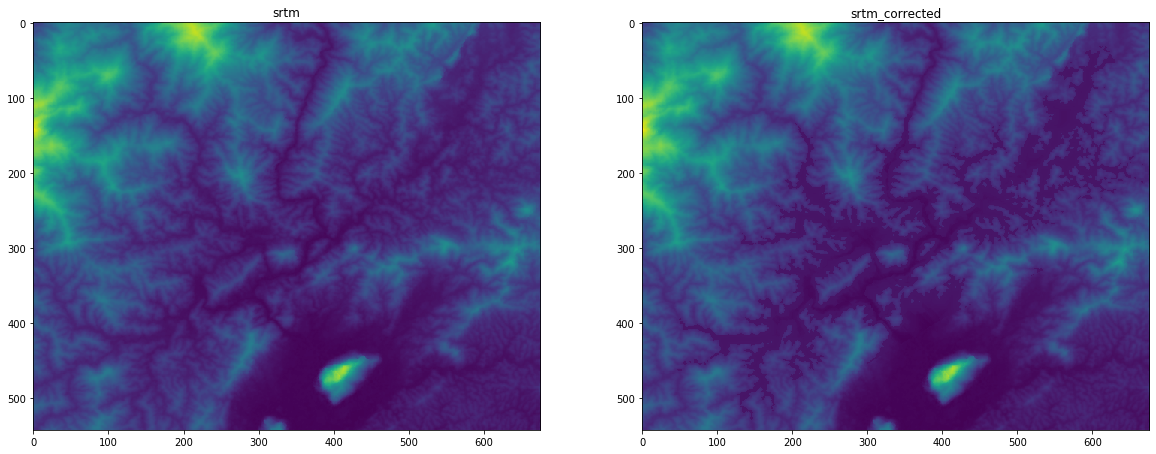

Nam Ngum


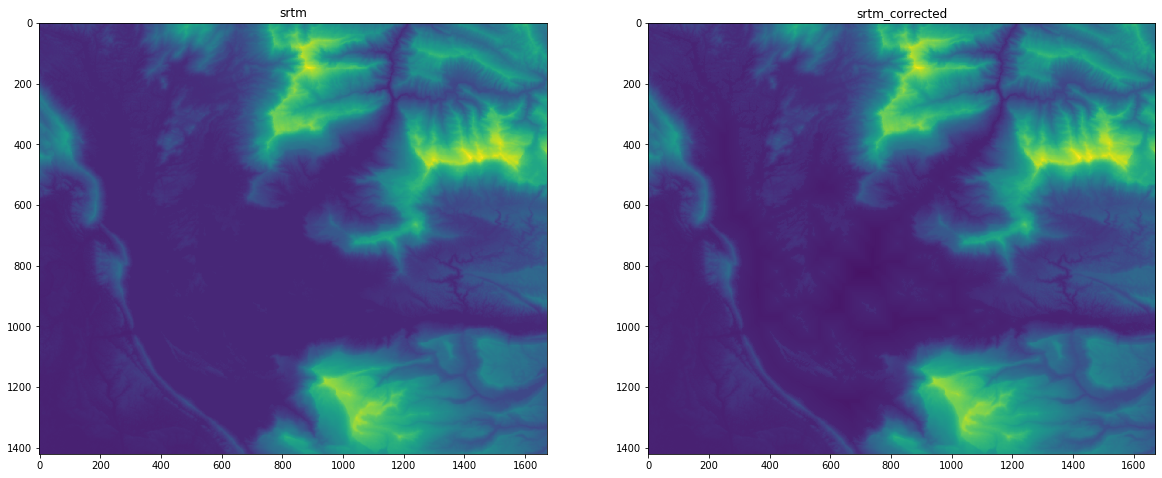

In [13]:
pd.set_option('display.expand_frame_repr', False)
pd.options.display.float_format = '{:,.4f}'.format

for name, data in wbdDatas.items():
    df = data['df']
#     rrmse = (df['SignedError_srtm'] ** 2).mean() ** 0.5
#     rrmse_corrected = (df['SignedError_srtm_corrected'] ** 2).mean() ** 0.5
#     print(name, '{:.2f}%'.format(rrmse * 100), '{:.2f}%'.format(rrmse_corrected * 100))
#     print(name + '\n', df[[
# #        'SignedError_aster',
#        'SignedError_srtm',
# #        'SignedError_aster_corrected',
#        'SignedError_srtm_corrected',
# #        'AbsError_aster',
#        'AbsError_srtm',
# #        'AbsError_aster_corrected',
#        'AbsError_srtm_corrected',
#                           ]].describe().loc[['count', 'max', 'mean', 'std']], end = '\n\n')
    print(name)
    plt.figure(figsize = (20, 10))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(data['srtm'])
    plt.title('srtm')
    ax = plt.subplot(1, 2, 2)
    ax.imshow(data['srtm_corrected'])  
    plt.title('srtm_corrected')
    plt.show()

In [33]:
d = resevoirs[['DAM_NAME', 'AREA_POLY']].copy(deep = True)
d['RRMSE_not_corrected'] = RRMSE
d['RRMSE_corrected'] = RRMSE_corrected
d[d['RRMSE_corrected'] > 1e-1]

,DAM_NAME,AREA_POLY,RRMSE_not_corrected,RRMSE_corrected
5092,Zibihe,7.87,0.102591,0.102591
5134,Nam Leuk,9.23,0.360854,0.360854
5144,Nam Pung,15.79,0.499681,0.499681
5146,Lam Pao,202.51,0.320305,0.320305
5147,Chulabhorn,6.96,0.410374,0.410374
5148,Huai Kum,1.84,0.524059,0.524059
5150,Tabsalao,15.18,0.575574,0.575574
5152,Lamtakhong,26.89,0.297443,0.297443
5156,Lamphraphloeng,9.69,0.432041,0.432041
5158,Lamnangrong,11.57,0.311867,0.311867


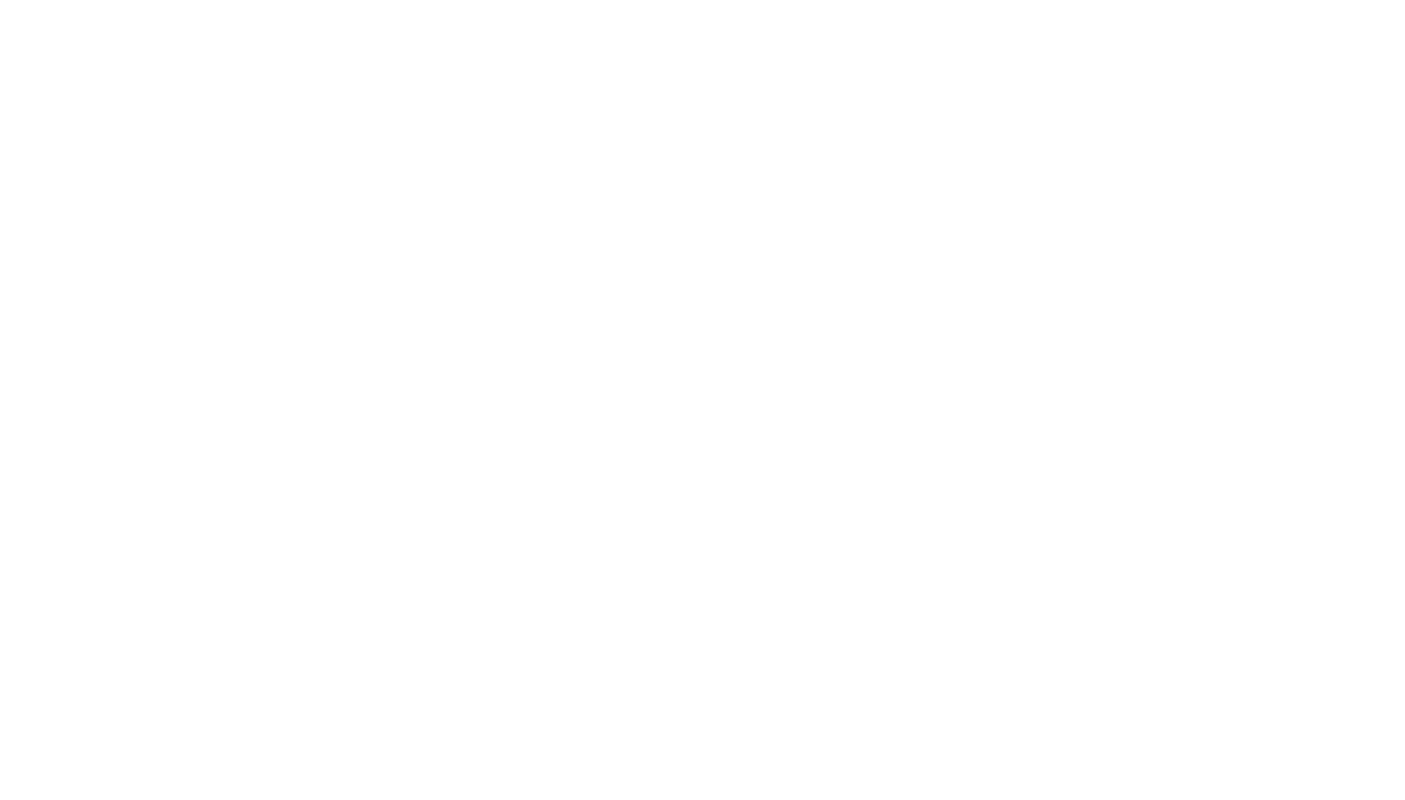

In [103]:
fig = go.Figure()
for key, data in wbdDatas.items():
    if True or key == 'Xe Kaman 1':
        df = data['df']
        fig.add_trace(go.Scatter(x = df.Date, y = df['WaterArea'], name = key))

fig.update_layout(xaxis_rangeslider_visible=True, height = 800)
fig.show()

In [39]:
d = wbdDatas['Lam Pao']['df']
d.loc[d.AbsError_srtm.idxmax()]

date                           2019-04-26 00:00:00
WaterPixels                                 103692
WaterArea                                  88.8726
Level_srtm                                     160
CountPredict_srtm                             4223
SignedError_srtm                         -0.959274
AbsError_srtm                             0.959274
Level_srtm_corrected                           160
CountPredict_srtm_corrected                   4223
SignedError_srtm_corrected               -0.959274
AbsError_srtm_corrected                   0.959274
Name: 80, dtype: object

In [31]:
def plot(data, date = None, scale = 1 / 8):
    name = data['name']
    dem = (data['srtm_corrected']).T.copy()
    mask = data['srtm_mask'].T
    df = data['df']
    resolution = 1
    
    x = np.linspace(0, dem.shape[0], dem.shape[0] // resolution)
    y = np.linspace(0, dem.shape[1], dem.shape[1] // resolution)
    if date is not None:
        level = df[df.date == date].Level_srtm_corrected.iloc[0]
        downsampled = cv2.resize(dem, None, fx = scale, fy = scale)
        water = cv2.resize(mask * level, None, fx = scale, fy = scale)
        plotData = [go.Surface(x = x, y = y, z = downsampled), go.Surface(x = x, y = y, z = water, showscale = False)]
    else:
        downsampled = cv2.resize(dem, None, fx = scale, fy = scale)
        plotData = [go.Surface(x = x, y = y, z = downsampled)]
    
    fig = go.Figure(data = plotData)
    
    fig.update_layout(title = name + ' Elevation' + (' ' + date if date != None else ''), autosize=False,
                      width = 1000, height=800,
                      margin = dict(l=65, r=50, b=65, t=90),
                      scene = dict(aspectmode = 'manual', aspectratio = dict(x = 1, y = dem.shape[0] / dem.shape[1], z = 1 / 30)))

    fig.show()
def plotMany(data, names, date = None, scale = 1 / 16):
    for name in names:
        plot(data[name], date, scale)

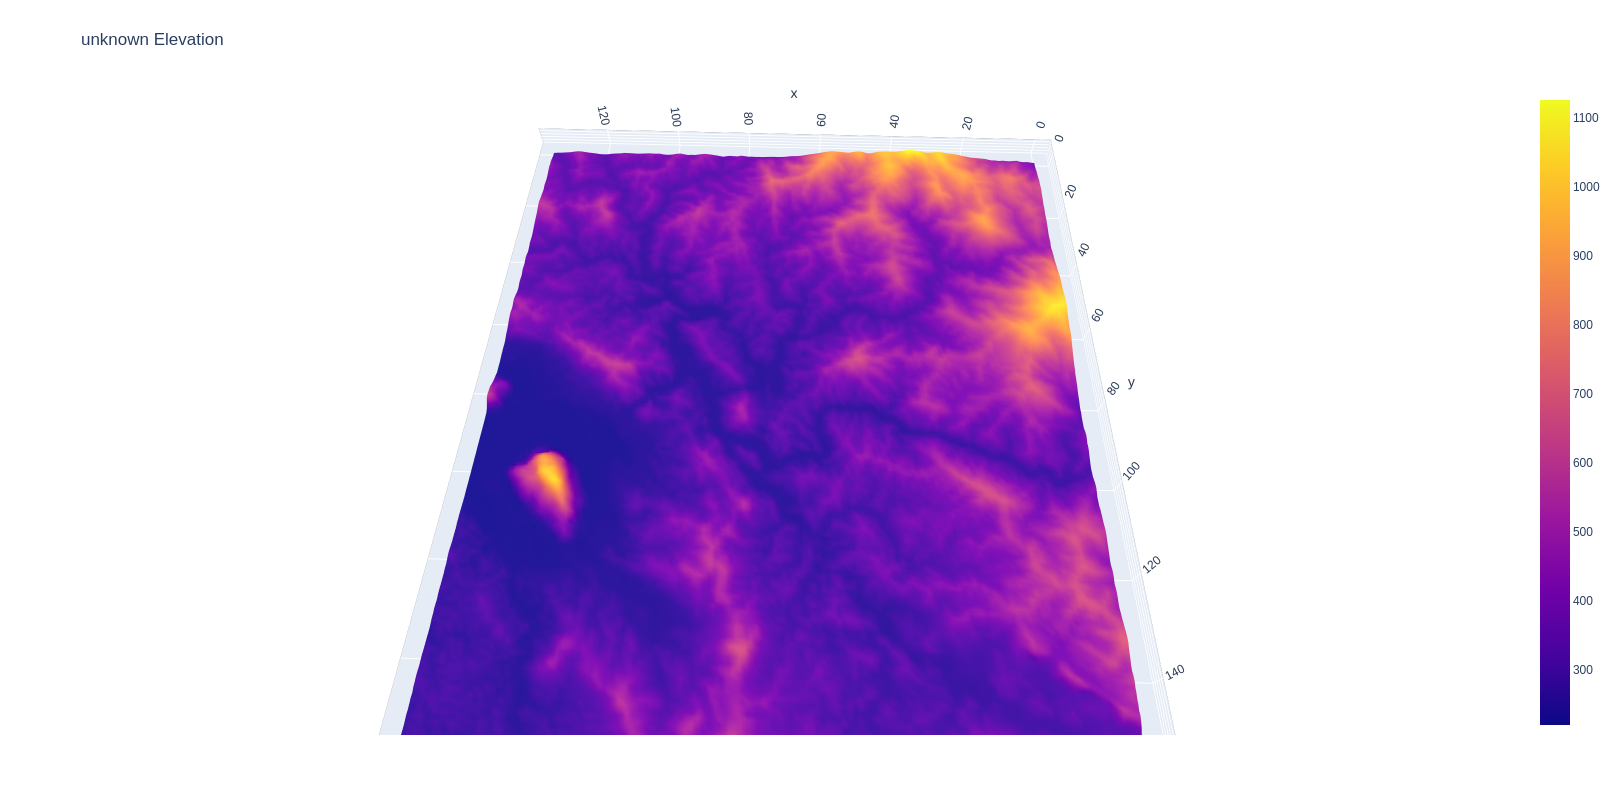

In [50]:
plotMany(wbdDatas, ['Na'],
         date = None,
         scale = 1 / 4)

In [112]:
def plotInteractive(data, scale = 1 / 4):
    dem = (data['srtm_corrected']).T
    mask = data['srtm_mask'].T
    df = data['df']
    resolution = 1
    downsampled = cv2.resize(dem, None, fx = scale, fy = scale)

    x = np.linspace(0, dem.shape[0], dem.shape[0] // resolution)
    y = np.linspace(0, dem.shape[1], dem.shape[1] // resolution)

    level = df.loc[0]['Level']
    water = np.where(mask == 1, np.ones_like(dem) * level, 0)
    water = cv2.resize(water, None, fx = scale, fy = scale)

    fig = go.FigureWidget(data = [go.Surface(x = x, y = y, z = downsampled), go.Surface(x = x, y = y, z = water, showscale = False)])
    fig.update_layout(autosize=False,
                          width = 1000, height=800,
                          margin = dict(l=65, r=50, b=65, t=90),
                          scene = dict(aspectmode = 'manual', aspectratio = dict(x = 1, y = dem.shape[0] / dem.shape[1], z = 1 / 30)))
    slider = widgets.SelectionSlider(options = df.Date, description='Date')
    slider.layout.width = '800px'

    # our function that will modify the xaxis range
    def update_range(date):
        with fig.batch_update():
            level = df[df.Date == date]['Level'].values[0]
            water = cv2.resize(mask * level, None, fx = scale, fy = scale)
            fig.data[1].z = water


    # display the FigureWidget and slider with center justification
    vb = VBox((fig, interactive(update_range, date = slider)))
    vb.layout.align_items = 'center'
    return vb

In [113]:
plotInteractive(wbdDatas['Nam Ngum'])

    'data': [{'type': 'surface',
              'uid': '95667e93-b747-4e56-9301-0…

In [40]:
wbdDatas['Haixihai']['df']

,date,WaterPixels,WaterArea,Level_srtm,CountPredict_srtm,SignedError_srtm,AbsError_srtm,Level_srtm_corrected,CountPredict_srtm_corrected,SignedError_srtm_corrected,AbsError_srtm_corrected
1,2018-01-07,5637.133333,4.530482,2131,6178,0.095947,0.095947,2130,5226,-0.072933,0.072933
2,2018-01-13,5637.133333,4.530482,2131,6178,0.095947,0.095947,2130,5226,-0.072933,0.072933
3,2018-01-19,5033.694118,4.045480,2131,6178,0.227329,0.227329,2130,5226,0.038204,0.038204
4,2018-01-25,5033.694118,4.045480,2131,6178,0.227329,0.227329,2130,5226,0.038204,0.038204
5,2018-01-31,5230.643137,4.203766,2131,6178,0.181117,0.181117,2130,5226,-0.000888,0.000888
...,...,...,...,...,...,...,...,...,...,...,...
102,2019-09-05,4433.207843,3.562879,2131,6178,0.393573,0.393573,2129,4441,0.001758,0.001758
103,2019-09-11,4710.584314,3.785790,2131,6178,0.311515,0.311515,2129,4441,-0.057229,0.057229
104,2019-09-17,4885.925490,3.926734,2131,6178,0.264448,0.264448,2130,5226,0.069603,0.069603
105,2019-09-23,4737.098039,3.807087,2131,6178,0.304174,0.304174,2129,4441,-0.062506,0.062506
